In [145]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier # 1. Import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)

df = pd.read_csv("kepler_objects_of_interest.csv", comment="#")




In [146]:
def preprocess_data(data):
    columns_to_keep = [
        'koi_period',
        'koi_ror',
        'koi_prad',
        'koi_dor',
        'koi_depth',
        'koi_model_snr', 
        'koi_steff',
        'koi_slogg',
        'koi_srad',
        'koi_fpflag_nt',
        'koi_fpflag_ss',
        'koi_fpflag_co', 
        'koi_fpflag_ec', 
        'koi_impact',
        'koi_duration',
        #and the target variable
        'koi_disposition'
    ]
    processed_data = data[columns_to_keep].copy()
    processed_data = processed_data.dropna()#dropping the missing values instead of filling them as it can distort the data
    
    return processed_data

In [147]:
#we have made a function of preprocessing the data which selects the columns and drops the missing values

final_df = preprocess_data(df)
final_df["koi_disposition"] = final_df["koi_disposition"].map({'CONFIRMED': 2, 'CANDIDATE': 1, 'FALSE POSITIVE': 0})
#we can also add features ourselves to enhance the model and thats called feature engineering


In [148]:
#making features and target variable
X = final_df.drop("koi_disposition", axis=1)
Y = final_df["koi_disposition"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)#will learn with 80% of data and test with 20% of data

In [149]:
def tune_rf_hyperparameters(X_train, Y_train):
    # This grid is a starting point. It can take a while to run!
    # You can reduce the options to speed it up.
    param_grid = {
        'n_estimators': [100, 200],         # Number of trees in the forest
        'max_depth': [10, 20, None],        # Max depth of the tree (None means no limit)
        'min_samples_split': [2, 5],        # Min samples required to split a node
    }
    # Use n_jobs=-1 to use all available CPU cores
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    print(f"Best parameters found: {grid_search.best_params_}")
    return grid_search.best_estimator_

print("Tuning Random Forest hyperparameters... this may take a few minutes.")
best_rf_model = tune_rf_hyperparameters(X_train, Y_train)



Tuning Random Forest hyperparameters... this may take a few minutes.
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [150]:
#predictions and evaluation
def evaluate_model(model, X_test, Y_test):
    prediction = model.predict(X_test)
    accuracy = accuracy_score(Y_test, prediction)
    matrix = confusion_matrix(Y_test, prediction)
    return accuracy, matrix

accuracy, matrix = evaluate_model(best_rf_model, X_test, Y_test)
print(f"Random Forest Model Accuracy: {accuracy*100:.2f}%")
print("Confusion Matrix:")
print(matrix)



Random Forest Model Accuracy: 92.45%
Confusion Matrix:
[[880   6   1]
 [  2 335  68]
 [  4  58 487]]


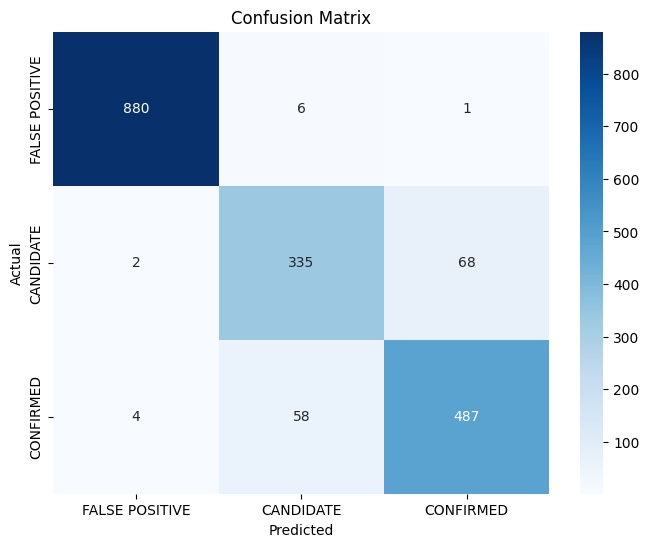

In [151]:
def plot_confusion_matrix(matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FALSE POSITIVE', 'CANDIDATE', 'CONFIRMED'], yticklabels=['FALSE POSITIVE', 'CANDIDATE', 'CONFIRMED'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(matrix)

C:\Users\rohan\AppData\Local\Temp\ipykernel_3524\3464841220.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_series, y=feature_importance_series.index, palette='viridis')


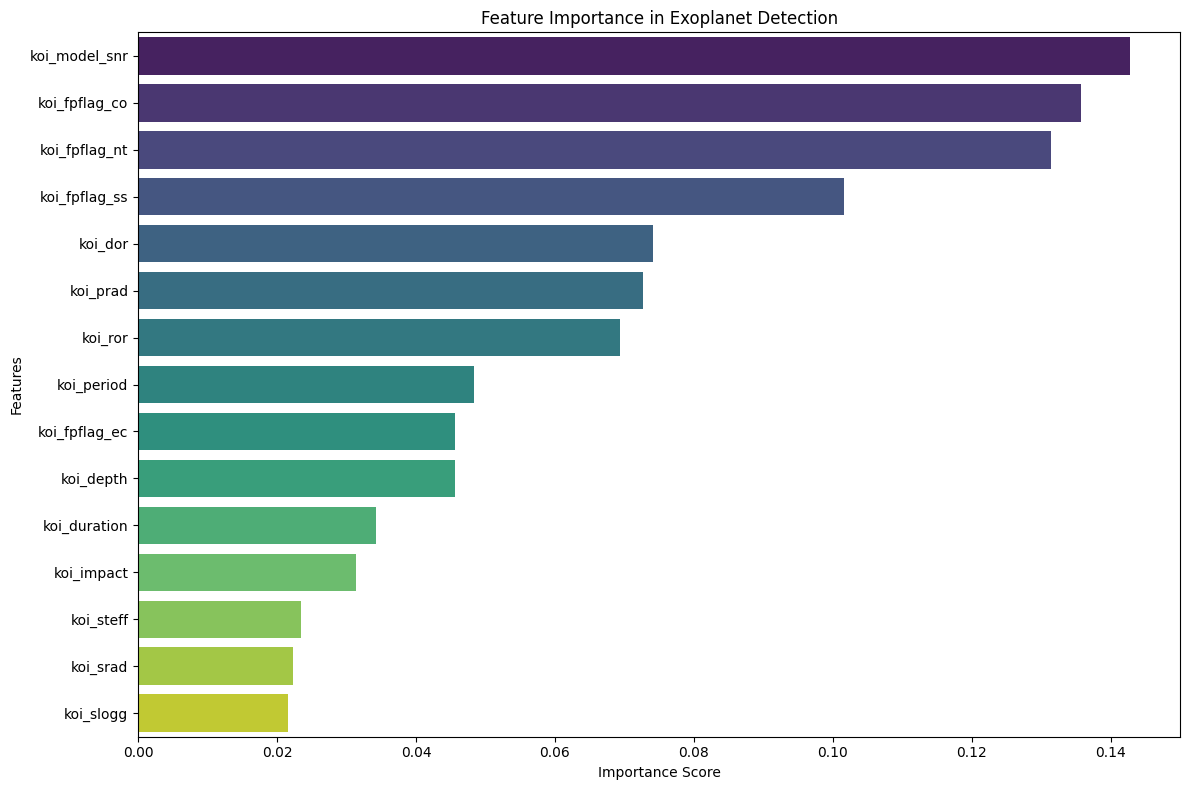

In [152]:
# Assuming 'best_rf_model' is your trained RandomForest model and 'X' is your features DataFrame

# 1. Get importance scores and feature names from the trained model
importances = best_rf_model.feature_importances_
feature_names = X.columns

# 2. Create a pandas Series for easy sorting and plotting
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 3. Plot the results as a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_series, y=feature_importance_series.index, palette='viridis')

# Add titles and labels for clarity
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in Exoplanet Detection')
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()